*Библиотеки*

In [207]:
import ccxt
import pandas as pd
import numpy as np
import requests

import vectorbt as vbt

import pyarrow as pa
import pyarrow.parquet as pq
import duckdb

import quantstats as qs
import empyrical as emp

from datetime import datetime, timezone

*Настройки*

In [508]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 0)
exchange = ccxt.binance({"enableRateLimit": True})

**Функции**

In [208]:
# Объем измеряется в количестве актива проторгованном за свечу (т.е 100 биткоинов было проторговано за эту часовую/минутную/дневную свечу)
def fetch_ohlcv_df(exchange, symbol, timeframe, start, end):
    start_ms = int(pd.Timestamp(start, tz="UTC").timestamp() * 1000)
    end_ms = int(pd.Timestamp(end, tz="UTC").timestamp() * 1000)

    data = []
    since = start_ms

    while since < end_ms:
        batch = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
        if not batch:
            break
        data.extend(batch)
        since = batch[-1][0] + 1

    df = pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True)
    df = df.set_index("timestamp")
    return df.loc[start:end]

In [621]:
def moex_fetch_ohlcv_df(ticker, timeframe, start, end, board="TQBR"):
    tf = {"1m": 1, "10m": 10, "1h": 60, "1d": 24, "1w": 7, "1M": 31, "1Q": 4}
    interval = tf[timeframe]

    url = f"https://iss.moex.com/iss/engines/stock/markets/shares/boards/{board}/securities/{ticker}/candles.json"
    start_ts = pd.Timestamp(start, tz="UTC")
    end_ts   = pd.Timestamp(end, tz="UTC")

    rows, off = [], 0
    while True:
        r = requests.get(url, params={"from": start, "till": end, "interval": interval, "start": off}).json()["candles"]
        chunk = r["data"]
        if not chunk:
            break
        rows += chunk
        off += len(chunk)

    df = pd.DataFrame(rows, columns=r["columns"])
    df["timestamp"] = pd.to_datetime(df["begin"]).dt.tz_localize("Europe/Moscow").dt.tz_convert("UTC")
    df = df.set_index("timestamp")[["open","high","low","close","volume"]]
    return df.loc[start_ts:end_ts]

*Проверка работоспособности*

In [628]:
df = fetch_ohlcv_df(
    exchange,
    "TON/USDT",
    "1M",
    "2025-01-01",
    "2026-01-01"
)

In [629]:
df

,open,high,low,close,volume
timestamp,,,,,
2025-01-01 00:00:00+00:00,5.507,5.838,4.670,4.827,1.629600e+08
2025-02-01 00:00:00+00:00,4.829,4.914,2.978,3.328,1.796963e+08
2025-03-01 00:00:00+00:00,3.329,4.167,2.354,4.109,2.815950e+08
2025-04-01 00:00:00+00:00,4.109,4.211,2.778,3.161,2.383139e+08
2025-05-01 00:00:00+00:00,3.162,3.698,2.882,3.148,2.727024e+08
2025-06-01 00:00:00+00:00,3.149,3.395,2.604,2.912,1.637293e+08
2025-07-01 00:00:00+00:00,2.912,3.688,2.717,3.529,3.218906e+08
2025-08-01 00:00:00+00:00,3.528,3.749,3.021,3.165,2.898410e+08
2025-09-01 00:00:00+00:00,3.165,3.266,2.581,2.710,1.534750e+08


In [ ]:
df = moex_fetch_ohlcv_df(
    "SELG",
    "1M",
    "2025-02-02",
    "2026-02-02"
)

In [640]:
df

,open,high,low,close,volume
timestamp,,,,,
2025-02-28 21:00:00+00:00,50.40,54.89,48.35,50.29,136568190
2025-03-31 21:00:00+00:00,50.38,52.96,43.52,49.32,109066980
2025-04-30 21:00:00+00:00,49.59,49.71,42.00,43.53,33658400
2025-05-31 21:00:00+00:00,43.20,47.45,41.81,43.61,47102820
2025-06-30 21:00:00+00:00,43.61,51.88,39.54,47.71,164748850
2025-07-31 21:00:00+00:00,47.77,51.99,46.55,47.85,100252610
2025-08-31 21:00:00+00:00,47.85,48.90,43.34,43.54,73831300
2025-09-30 21:00:00+00:00,43.75,47.26,41.89,42.49,68876553
2025-10-31 21:00:00+00:00,42.51,45.97,42.29,42.83,44347860


In [506]:
df[['open','high','low','close','volume']].vbt.ohlcv.plot() # Работает только без объема почему-то. ohlcv при добавлении объема не работает!

FigureWidget({
    'data': [{'close': {'bdata': ('vq8+3N0csT7XEAP60EexPtcQA/rQR7' ... 'pn09E+OJUUcZ3z0T4gNFBTqsjRPg=='),
                        'dtype': 'f8'},
              'decreasing': {'line': {'color': '#d95f02'}},
              'high': {'bdata': ('1xAD+tBHsT7vcccXxHKxPu9xxxfEcr' ... 'ng6NE+fq2FOFr+0T44lRRxnfPRPg=='),
                       'dtype': 'f8'},
              'increasing': {'line': {'color': '#1b9e76'}},
              'low': {'bdata': ('vq8+3N0csT6+rz7c3RyxPr6vPtzdHL' ... 'vtvdE+rGQy4iPe0T4gNFBTqsjRPg=='),
                      'dtype': 'f8'},
              'name': 'OHLC',
              'open': {'bdata': ('1xAD+tBHsT7XEAP60EexPtcQA/rQR7' ... 'OqyNE+rGQy4iPe0T44lRRxnfPRPg=='),
                       'dtype': 'f8'},
              'type': 'ohlc',
              'uid': 'add42a07-a71e-4893-bb28-e54bca331f32',
              'x': array([Timestamp('2024-02-10 07:00:00+0000', tz='UTC'),
                          Timestamp('2024-02-10 08:00:00+0000', tz='UTC'),
                  

In [603]:
close = df['close']

df['ema_8'] = vbt.MA.run(close, window = 8, ewm = True).ma
df['ema_14'] = vbt.MA.run(close, window = 14, ewm = True).ma
df['ema_50'] = vbt.MA.run(close, window = 50, ewm = True).ma
df['ema_200'] = vbt.MA.run(close, window = 200, ewm = True).ma
df['sma_8'] = vbt.MA.run(close, window = 8, ewm = False).ma
df['sma_14'] = vbt.MA.run(close, window = 14, ewm = False).ma
df['sma_50'] = vbt.MA.run(close, window = 50, ewm = False).ma
df['sma_200'] = vbt.MA.run(close,window = 200, ewm = False).ma
df['rsi_14'] = vbt.RSI.run(close, window = 14).rsi
df['volume_ema_200'] = vbt.MA.run(df['volume'],window = 200, ewm = True).ma
df['volume_bullish'] = (df['volume'].rolling(3).apply(lambda x: x[0] < x[1] < x[2], raw=True).astype(bool))

In [604]:
df = df.dropna()
len(df)

8585

In [605]:
df.tail(25)

,open,high,low,close,volume,ema_8,ema_14,ema_50,ema_200,sma_8,sma_14,sma_50,sma_200,rsi_14,volume_ema_200,volume_bullish
timestamp,,,,,,,,,,,,,,,,
2025-12-31 23:00:00+00:00,1.664,1.664,1.654,1.659,190262.44,1.648337,1.642135,1.628325,1.585936,1.642750,1.639643,1.61656,1.572085,62.105263,264168.716308,False
2026-01-01 00:00:00+00:00,1.659,1.673,1.658,1.664,210436.76,1.651818,1.645050,1.629724,1.586713,1.648000,1.642143,1.61810,1.573045,68.817204,263634.069977,False
2026-01-01 01:00:00+00:00,1.663,1.677,1.660,1.670,159853.34,1.655858,1.648377,1.631303,1.587542,1.654125,1.644643,1.62008,1.574080,68.817204,262601.425898,False
2026-01-01 02:00:00+00:00,1.670,1.680,1.665,1.672,191777.22,1.659445,1.651526,1.632899,1.588382,1.658500,1.647286,1.62216,1.575050,69.473684,261896.707431,False
2026-01-01 03:00:00+00:00,1.671,1.679,1.670,1.676,154083.85,1.663124,1.654790,1.634589,1.589254,1.663375,1.649500,1.62440,1.576045,67.415730,260823.942680,False
2026-01-01 04:00:00+00:00,1.676,1.677,1.667,1.670,141236.69,1.664652,1.656818,1.635978,1.590057,1.666625,1.652000,1.62668,1.576985,70.588235,259634.019768,False
2026-01-01 05:00:00+00:00,1.671,1.689,1.671,1.688,129378.88,1.669840,1.660975,1.638018,1.591032,1.670375,1.655857,1.62922,1.578030,76.470588,258337.948726,False
2026-01-01 06:00:00+00:00,1.688,1.690,1.678,1.682,166055.94,1.672543,1.663779,1.639743,1.591937,1.672625,1.660143,1.63132,1.579020,81.250000,257419.719783,False
2026-01-01 07:00:00+00:00,1.681,1.685,1.655,1.658,319560.95,1.669311,1.663008,1.640459,1.592594,1.672500,1.662786,1.63286,1.579890,65.546218,258038.040482,True


<Axes: xlabel='timestamp'>

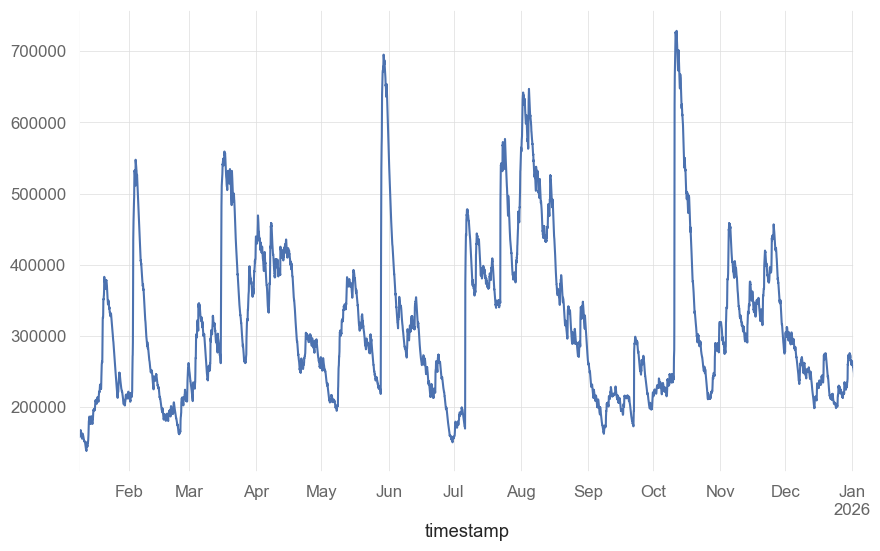

In [569]:
df['volume_ema_200'].plot()

**Тестовая стратегия**

In [606]:
entries = (df['close'] > df["sma_50"]) & (df['volume'] > df['volume_ema_200']) & df['volume_bullish']
exits = (df['sma_14'] < df["sma_50"]) & (df['volume'] < df["volume_ema_200"]) |  (~(df['volume_bullish'])) & (df['volume'] < df["volume_ema_200"])

In [592]:
entries = (df['ema_8'] > df["ema_200"])
#exits = (df['close'] < df["ema_200"]) | (df['volume'] < df["volume_ema_200"])

In [607]:
close = df['close']
pf = vbt.Portfolio.from_signals(close,entries = entries, freq="1h", sl_stop=0.01, tp_stop= 0.1)
pf.stats()

Start                         2025-01-09 07:00:00+00:00
End                           2026-01-01 23:00:00+00:00
Period                                357 days 17:00:00
Start Value                                       100.0
End Value                                     43.682807
Total Return [%]                             -56.317193
Benchmark Return [%]                         -67.435602
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              61.928158
Max Drawdown Duration                 348 days 23:00:00
Total Trades                                        114
Total Closed Trades                                 113
Total Open Trades                                     1
Open Trade PnL                                  1.52142
Win Rate [%]                                   7.079646
Best Trade [%]                                13.609073
Worst Trade [%]                               -8

In [608]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'cb147f42-c5ae-45c6-b5f6-220868573ee6',
              'x': array([Timestamp('2025-01-09 07:00:00+0000', tz='UTC'),
                          Timestamp('2025-01-09 08:00:00+0000', tz='UTC'),
                          Timestamp('2025-01-09 09:00:00+0000', tz='UTC'), ...,
                          Timestamp('2026-01-01 21:00:00+0000', tz='UTC'),
                          Timestamp('2026-01-01 22:00:00+0000', tz='UTC'),
                          Timestamp('2026-01-01 23:00:00+0000', tz='UTC')],
                         shape=(8585,), dtype=object),
              'xaxis': 'x',
              'y': {'bdata': ('AiuHFtnOFEArhxbZzvcUQKrx0k1iEB' ... 'uHFvs/CKwcWmQ7+z+0yHa+nxr7Pw=='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'customdata': {'bdata': ('AA

<Axes: xlabel='timestamp'>

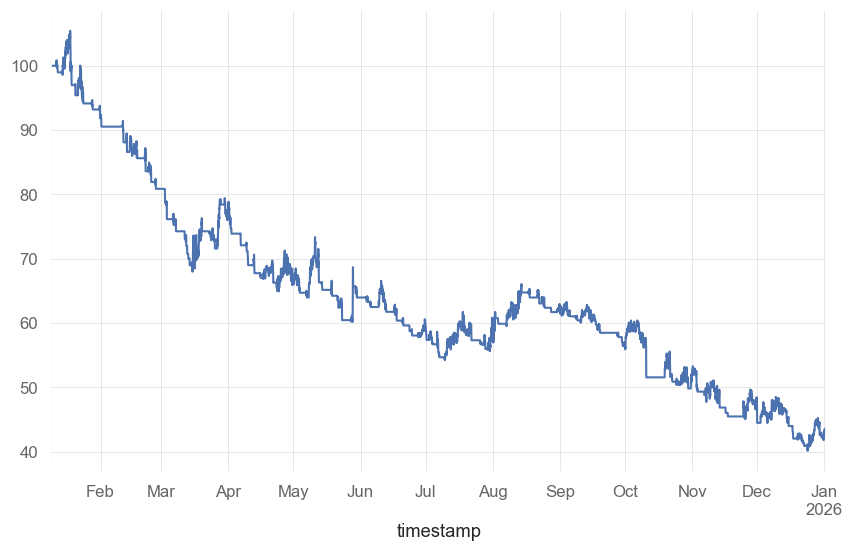

In [609]:
pf.trades.records_readable
pf.value().plot()

In [17]:
close = df["close"]
ema = df["ema_50"]
vol = df["volume"]

w = 50
k = 3.0
n = 4

vol_mean = vol.rolling(w).mean()
vol_std  = vol.rolling(w).std()
spike = vol > (vol_mean + k * vol_std)

bull = df["close"] > df["open"]
bear = df["close"] < df["open"]

prev4_bull = bull.shift(1).rolling(n).sum() == n
prev4_bear = bear.shift(1).rolling(n).sum() == n

short_entries_raw = spike & bull & prev4_bull
long_entries_raw  = spike & bear & prev4_bear

long_entries  = long_entries_raw.shift(1).fillna(False)
short_entries = short_entries_raw.shift(1).fillna(False)

cross_ema_up   = (ema.shift(1) < close.shift(1)) & (ema >= close)   # EMA crosses above price
cross_ema_down = (ema.shift(1) > close.shift(1)) & (ema <= close)   # EMA crosses below price

long_exits  = cross_ema_up.shift(1).fillna(False)
short_exits = cross_ema_down.shift(1).fillna(False)


/var/folders/wv/62jmd95s1f14n4w8zh58m7680000gn/T/ipykernel_11444/196356676.py:22: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/wv/62jmd95s1f14n4w8zh58m7680000gn/T/ipykernel_11444/196356676.py:23: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/wv/62jmd95s1f14n4w8zh58m7680000gn/T/ipykernel_11444/196356676.py:28: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_opt

Start                         2025-02-10 07:00:00+00:00
End                           2026-02-02 23:00:00+00:00
Period                                357 days 17:00:00
Start Value                                       100.0
End Value                                      96.58401
Total Return [%]                               -3.41599
Benchmark Return [%]                         -19.184289
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              17.623526
Max Drawdown Duration                 202 days 09:00:00
Total Trades                                         25
Total Closed Trades                                  25
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       60.0
Best Trade [%]                                 5.183331
Worst Trade [%]                              -11

<Axes: xlabel='timestamp'>

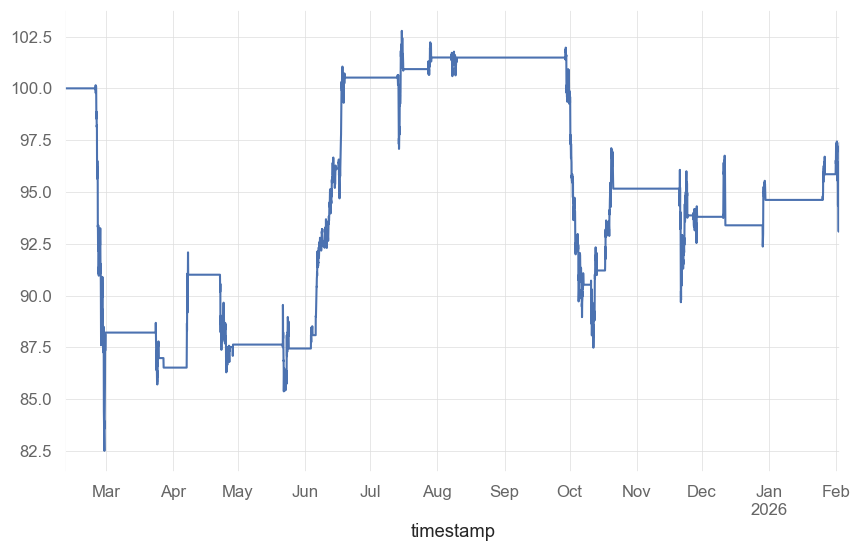

In [18]:
pf = vbt.Portfolio.from_signals(
    close,
    entries=long_entries,
    exits=long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    freq="1h",
)
print(pf.stats())
pf.trades.records_readable
pf.value().plot()